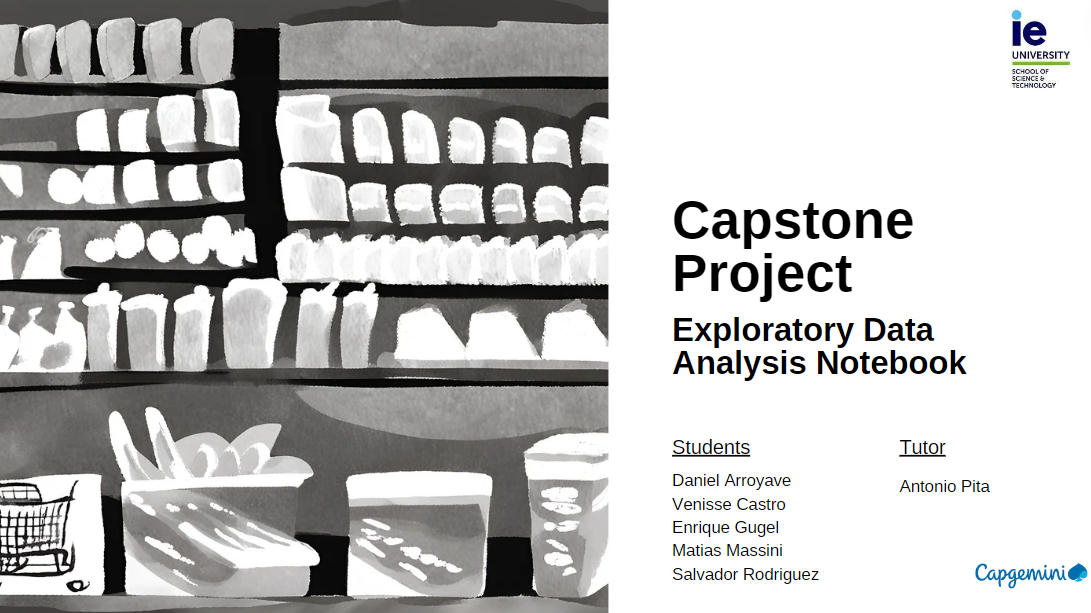

The purpose of this notebook is to perform an EDA on our dataset to have a clear view of the data and the business in order to find solutions for the customer.

# **1.   Libraries to be imported**



In [ ]:
import os
from google.colab import drive
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import KFold

from sklearn.cluster import KMeans

# **2.   Import Data**

We will create a Dataframe with each of the excel files providede by Capgemini



In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<mark>**IMPORTANT: Update the route the access the csv's**<mark>

* Route is the path to access the original csv's
* Destination is the path to save the datasets

In [ ]:
# Update the route to access the data:
#route = '/content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/df_merged_version.csv'
#destination = '/content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/'

#in case you accessing the google shared drive use this and discard the previous by adding a # before and deleting the # in the next line:
route = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged/df_merged_version.csv'
destination = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged'

In [ ]:
# Path to the CSV file
file_path = route

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

df.head(5)


,id_orden,id_producto,incluido_orden_carrito,reordenado,nombre_producto,id_pasillo,id_departamento,pasillo,departamento
0,1,49302,1,1,EL YOGUR DE BULGARIA,120.0,16.0,YOGUR,HUEVOS Y LÁCTEOS
1,1,11109,2,1,4% ORGÁNICO QUESO GRASA DE LECHE LECHE ENTERA ...,108.0,16.0,OTROS QUESOS CREMAS,HUEVOS Y LÁCTEOS
2,1,10246,3,0,CORAZONES DE APIO ORGÁNICOS,83.0,4.0,VEGETALES FRESCOS,FRUTAS Y VERDURAS
3,1,49683,4,0,KIRBY PEPINO,83.0,4.0,VEGETALES FRESCOS,FRUTAS Y VERDURAS
4,1,43633,5,1,LAS SARDINAS LIGERAMENTE AHUMADO EN ACEITE DE ...,95.0,15.0,MARISCOS CARNE ENLATADA,PRODUCTOS ENLATADOS


# **5. Data analysis**

# Orders

In [ ]:
# Calculate the number of unique orders
num_unique_orders = df['id_orden'].nunique()

print(f"Number of unique orders: {num_unique_orders}")

Number of unique orders: 131153


# Number of items per order

In [ ]:

# Assuming df is already defined and contains the necessary columns
# Group by 'id_orden' and aggregate the 'reordenado' column
df_total_order = df.groupby('id_orden')['reordenado'].sum().reset_index()

# Count the number of items in each order
no_items = df.groupby('id_orden').size().reset_index(name='numb_of_items')

# Merge the aggregated data and the item numbers
df_total_order = df_total_order.merge(no_items, on='id_orden')

# Sort df_total_order by the column 'numb_of_items'
df_total_order_sorted = df_total_order.sort_values(by='numb_of_items', ascending=False)

# Display the DataFrame
df_total_order_sorted


,id_orden,reordenado,numb_of_items
53962,1395075,47,79
107902,2813632,64,78
36759,949182,40,77
109992,2869702,60,75
13176,341238,49,75
...,...,...,...
79132,2054026,0,1
17637,456793,0,1
121742,3174962,0,1
17617,456186,1,1


In [ ]:
# Count the frequency of each number of items
item_counts = df_total_order_sorted['numb_of_items'].value_counts().reset_index()
item_counts.columns = ['numb_of_items', 'frequency']

# Create the bar chart with Plotly
fig = px.bar(item_counts, x='numb_of_items', y='frequency',
             labels={'numb_of_items': 'Number of Items in Order', 'frequency': 'Frequency'},
             title='Frequency of Number of Items in Orders')

# Show the plot
fig.show()

In [ ]:
# Create the boxplot with Plotly
fig = px.box(df_total_order_sorted, y='numb_of_items',
             labels={'numb_of_items': 'Number of Items in Order'},
             title='Distribution of Number of Items in Orders')

# Show the plot
fig.show()

In [ ]:
statistics = df_total_order_sorted['numb_of_items'].describe()

# Display the statistics
print(statistics)

count    131153.000000
mean         10.443520
std           7.852346
min           1.000000
25%           5.000000
50%           9.000000
75%          14.000000
max          79.000000
Name: numb_of_items, dtype: float64


The average number items per order is around 10 items, being the maximum 79 items and the minimum 1. There are no empty orders.

More than 28 items in an order are rare cases that could be considered outliers.

How is the distribution of products in terms of units sold?

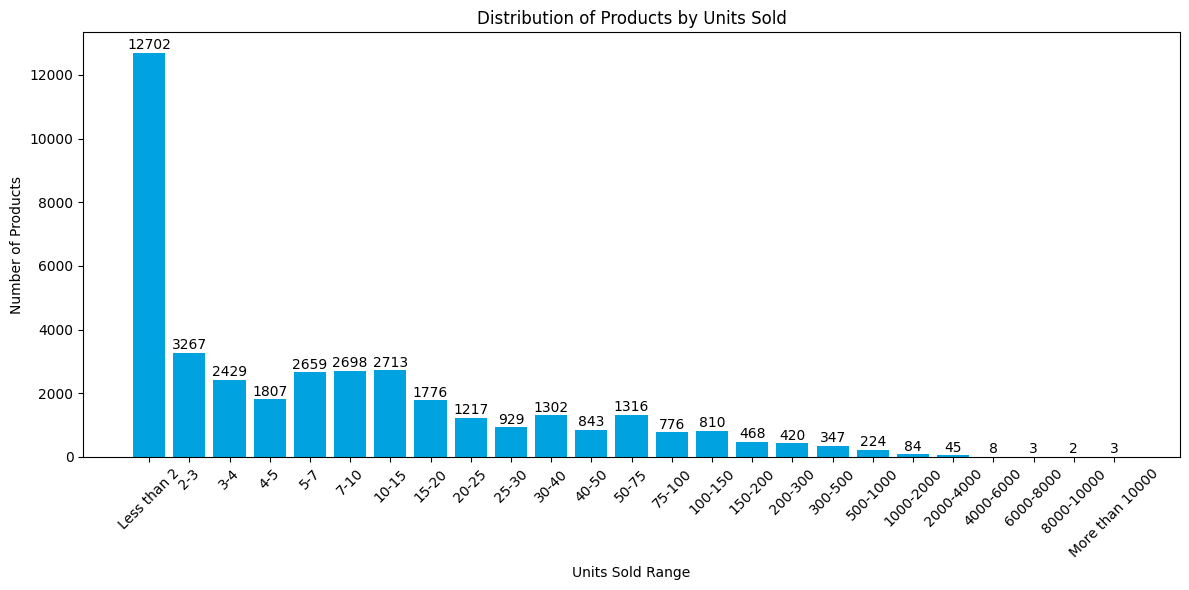

In [ ]:
# Group by 'id_producto' and count the occurrences to get the total units sold for each product
product_units = df['id_producto'].value_counts().reset_index()
product_units.columns = ['id_producto', 'units']

# Define the bins
bins = [float('-inf'), 2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50, 75, 100, 150, 200, 300, 500, 1000, 2000, 4000, 6000, 8000, 10000, float('inf')]
bin_labels = ['Less than 2', '2-3', '3-4', '4-5', '5-7', '7-10', '10-15', '15-20', '20-25', '25-30', '30-40', '40-50', '50-75', '75-100', '100-150', '150-200', '200-300', '300-500', '500-1000', '1000-2000', '2000-4000', '4000-6000', '6000-8000', '8000-10000', 'More than 10000']

# Assign bins to each product based on the number of units sold
product_units['unit_bins'] = pd.cut(product_units['units'], bins=bins, labels=bin_labels)

# Count the number of products in each bin
bin_counts = product_units['unit_bins'].value_counts().reindex(bin_labels, fill_value=0)

# Create the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(bin_counts.index, bin_counts.values, color='#00A3E0')
plt.title('Distribution of Products by Units Sold')
plt.xlabel('Units Sold Range')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.tight_layout()

# Add text labels to each bar
for bar, label in zip(bars, bin_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20, label, ha='center', va='bottom')

plt.show()


What are the top 50 products in units sold?

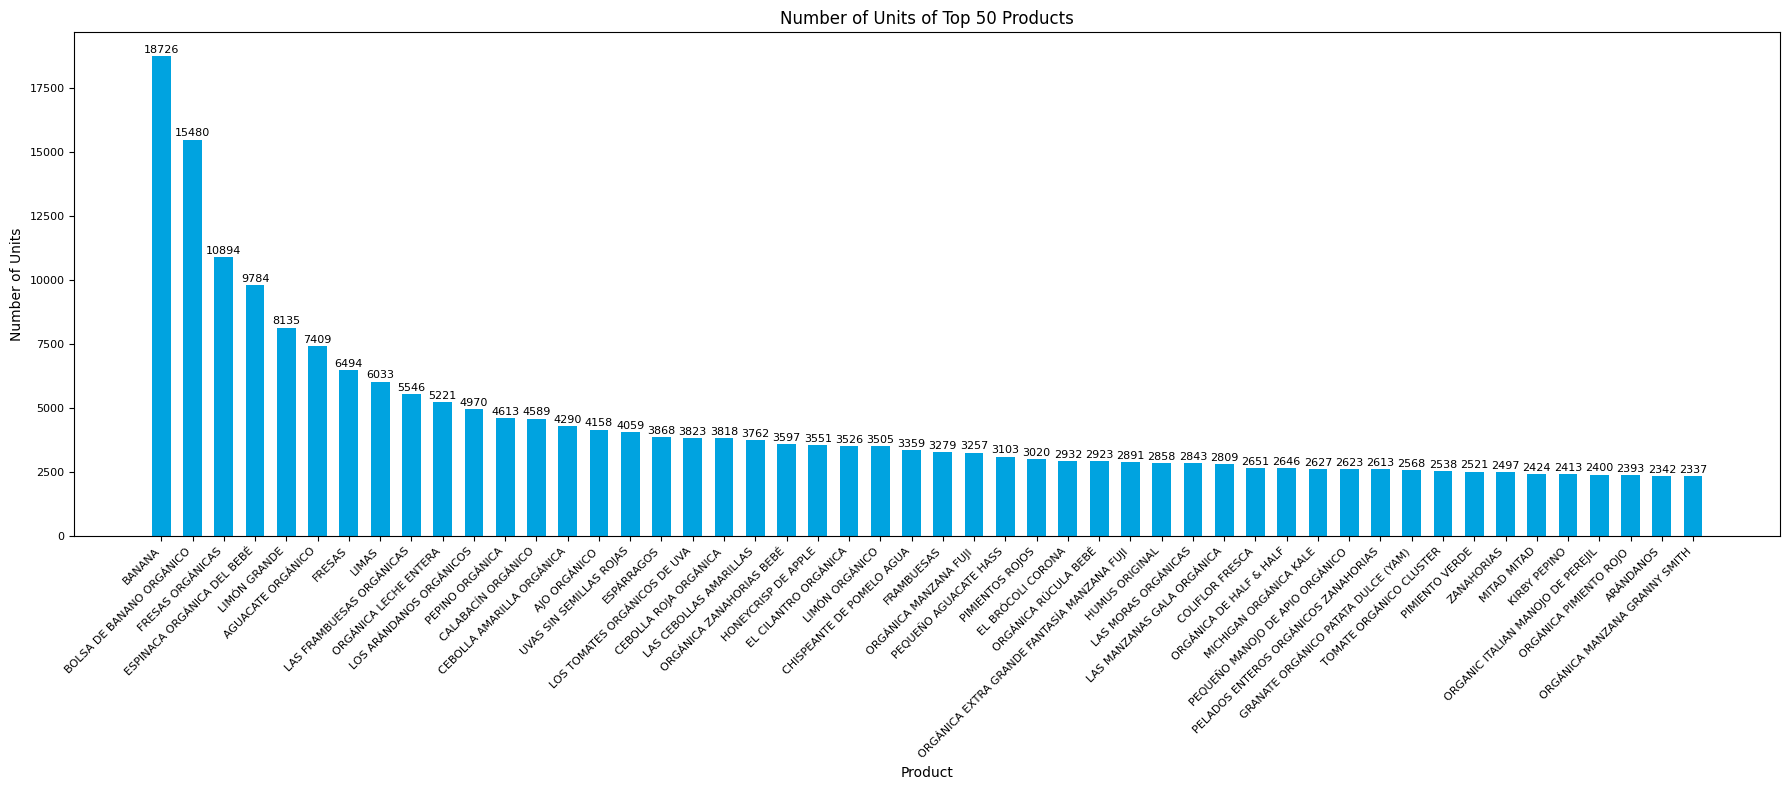

The total number of products wit 2 or less orders is  12538
This represents a  32.648 % of the total of data inputs.


In [ ]:
# Count the occurrences of each product
product_units = df['nombre_producto'].value_counts().reset_index()
product_units.columns = ['nombre_producto', 'units']

# Sort the DataFrame by units in descending order and select the top 50 products
top_50_products = product_units.head(50)

# Create the bar chart with wider space between bars
plt.figure(figsize=(18, 8))  # Adjust figure size
bars = plt.bar(top_50_products['nombre_producto'], top_50_products['units'], color='#00A3E0', width=0.6)  # Adjust bar width
plt.title('Number of Units of Top 50 Products')
plt.xlabel('Product')
plt.ylabel('Number of Units')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust x-axis label rotation and font size
plt.yticks(fontsize=8)  # Adjust y-axis label font size
plt.tight_layout()

# Add labels to the bars with smaller font size
for bar, label in zip(bars, top_50_products['units']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50, label, ha='center', va='bottom', fontsize=8)  # Adjust label font size

plt.show()

# productos innecesarios solo 1 o 2 pedidos  (se uso 2 de pedidos, pero pendiente por discutir)
less_ordered_prods = product_units[product_units["units"]<3]
no_less_ordered_prods = less_ordered_prods['units'].count()
total_data = product_units.shape[0]

print('The total number of products wit 2 or less orders is ', no_less_ordered_prods)
print('This represents a ', round((no_less_ordered_prods / total_data)* 100,3), '% of the total of data inputs.')


Most of the individual products have 2 sales or less, but if we compare this sales with the total number of sales they represent a meaningless number of transactions.

In the other side, there are only three products with more than 10.000 sales, another 7 with more than 5.000

# **Department Sales Analysis**

How many products are sold by department?

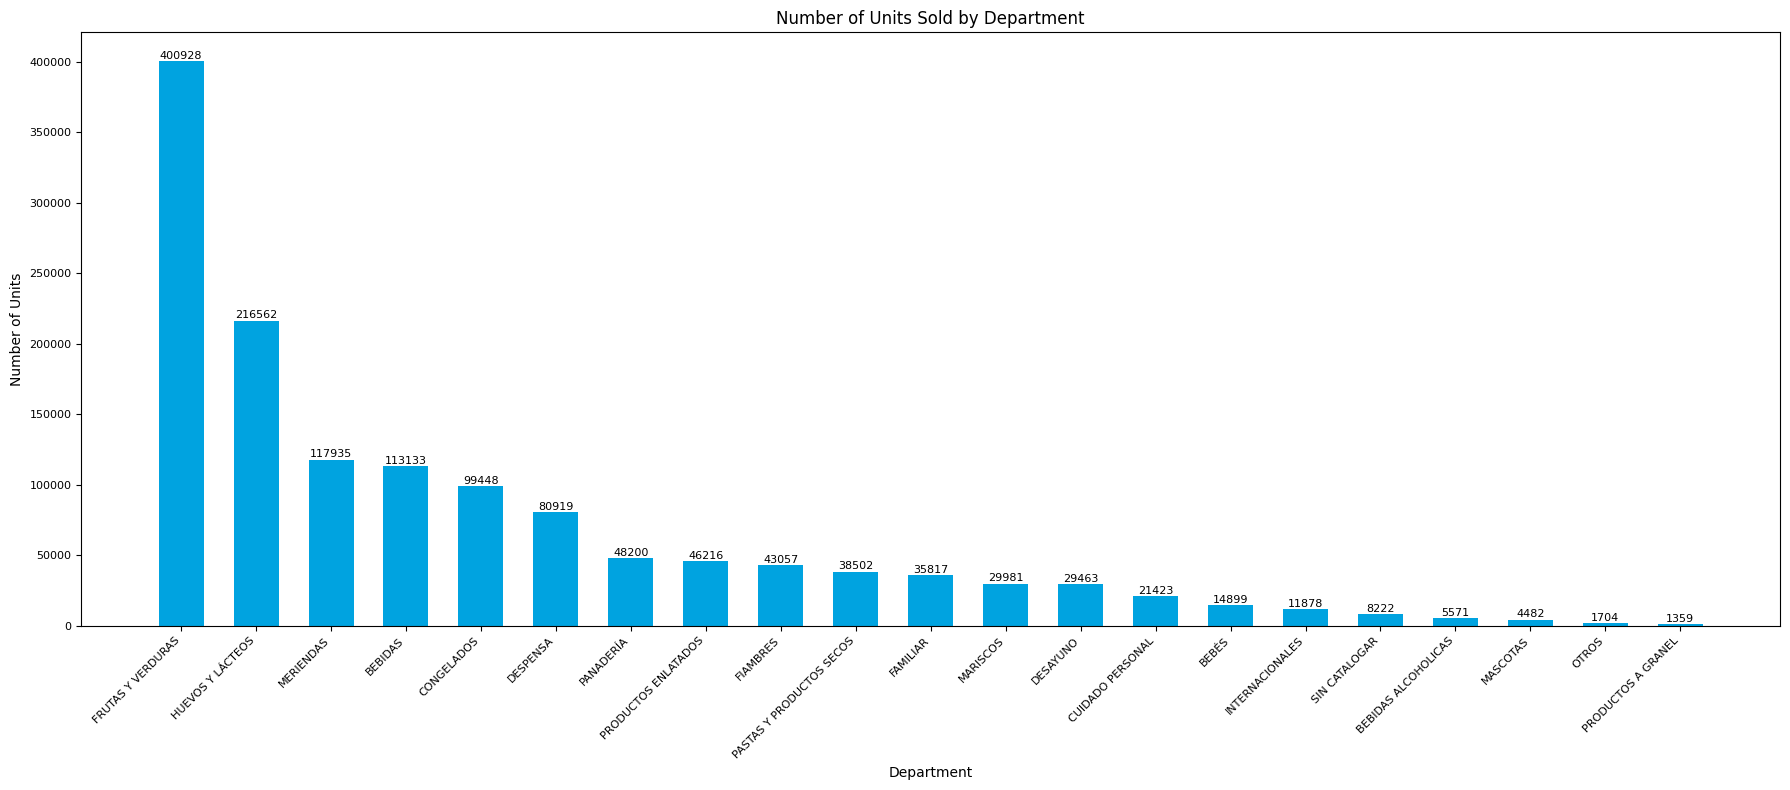

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each department
department_units = df['departamento'].value_counts().reset_index()
department_units.columns = ['departamento', 'units']

# Sort the DataFrame by units in descending order
department_units = department_units.sort_values(by='units', ascending=False)

# Create the bar chart with wider space between bars
plt.figure(figsize=(18, 8))  # Adjust figure size
bars = plt.bar(department_units['departamento'], department_units['units'], color='#00A3E0', width=0.6)  # Adjust bar width
plt.title('Number of Units Sold by Department')
plt.xlabel('Department')
plt.ylabel('Number of Units')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust x-axis label rotation and font size
plt.yticks(fontsize=8)  # Adjust y-axis label font size
plt.tight_layout()

# Add labels to the bars with smaller font size
for bar, label in zip(bars, department_units['units']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50, label, ha='center', va='bottom', fontsize=8)  # Adjust label font size

plt.show()


How many different products has each department?

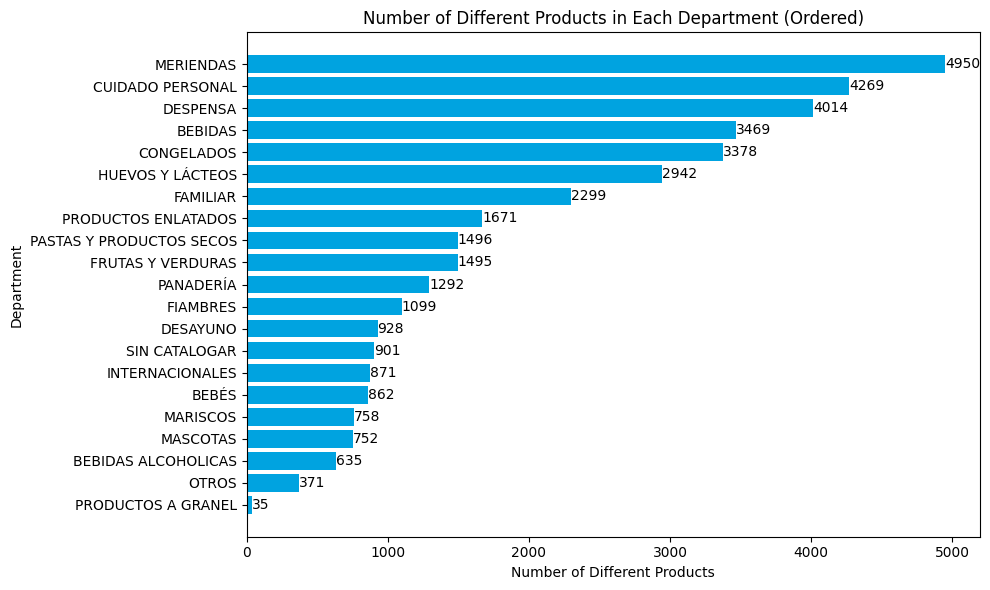

In [ ]:
products_in_department = {}

for department in df['departamento'].unique():
    products_in_department[department] = df[df['departamento'] == department]['nombre_producto'].nunique()

# Sort departments and product counts by product counts in descending order
sorted_departments = sorted(products_in_department.items(), key=lambda x: x[1], reverse=True)
departments = [dept[0] for dept in sorted_departments]
product_counts = [count[1] for count in sorted_departments]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(departments, product_counts, color='#00A3E0')
plt.xlabel('Number of Different Products')
plt.ylabel('Department')
plt.title('Number of Different Products in Each Department (Ordered)')
plt.gca().invert_yaxis()  # Invert y-axis to display departments from top to bottom

# Add labels to the bars
for bar in bars:
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', va='center', ha='left')

plt.tight_layout()
plt.show()

# **Aisles Analysis**

Are the aisles exclusive per department?

If so, how many aisles have each department?

In [ ]:
# Group by pasillo and count the number of unique departments
pasillo_department_counts = df.groupby('pasillo')['departamento'].nunique()

# Filter pasillos associated with more than one department
shared_pasillos = pasillo_department_counts[pasillo_department_counts > 1]

# Group by departamento and aggregate unique pasillos
department_pasillos = df.groupby('departamento')['pasillo'].unique()

if shared_pasillos.empty:
    print("EACH AISLE BELONGS TO JUSY ONE DEPARTMENT.")
else:
    print("The following pasillos belong to different departments:")
    print(shared_pasillos)

EACH AISLE BELONGS TO JUSY ONE DEPARTMENT.


In [ ]:
# Group by 'departamento' and count the number of unique 'pasillo' values
department_pasillos_count = df.groupby('departamento')['pasillo'].nunique().reset_index()

# Rename the columns for clarity
department_pasillos_count.columns = ['Department', 'Number of Aisles']

# Sort the DataFrame by the 'Number of Pasillos' column in descending order
department_pasillos_count_sorted = department_pasillos_count.sort_values(by='Number of Aisles', ascending=False)

# Display the sorted table
print(department_pasillos_count_sorted)

                  Department  Number of Aisles
4           CUIDADO PERSONAL                17
6                   DESPENSA                12
14                 MERIENDAS                11
3                 CONGELADOS                11
10          HUEVOS Y LÁCTEOS                10
7                   FAMILIAR                10
0                    BEBIDAS                 8
12                  MARISCOS                 7
8                   FIAMBRES                 5
9          FRUTAS Y VERDURAS                 5
1        BEBIDAS ALCOHOLICAS                 5
16                 PANADERÍA                 5
17  PASTAS Y PRODUCTOS SECOS                 5
19       PRODUCTOS ENLATADOS                 5
5                   DESAYUNO                 4
11           INTERNACIONALES                 4
2                      BEBÉS                 4
13                  MASCOTAS                 2
18        PRODUCTOS A GRANEL                 2
15                     OTROS                 1
20           

In [ ]:
# Group by aisle and count the number of unique departments
pasillo_department_counts = df.groupby('pasillo')['departamento'].nunique()

# Filter aisles associated with more than one department
shared_pasillos = pasillo_department_counts[pasillo_department_counts > 1]

# Group by departament and aggregate unique aisles
department_pasillos = df.groupby('departamento')['pasillo'].unique()

if shared_pasillos.empty:
    print("Each pasillo belongs to just one department.")
else:
    print("The following pasillos belong to different departments:")
    print(shared_pasillos)

# Print the aisles for each department
for department, pasillos in department_pasillos.items():
    print(f"{department}: {', '.join(pasillos)}")

Each pasillo belongs to just one department.
BEBIDAS: SELTZER AGUA Y AGUA CON GAS, REFRIGERADOS, NÉCTARES DE JUGO, BEBIDAS SIN ALCOHOL, TÉ, BEBIDAS DEPORTIVAS ENERGETICAS, CAFÉ, MEZCLAS DE BEBIDAS DE CACAO
BEBIDAS ALCOHOLICAS: VINOS BLANCOS, CERVEZAS REFRIGERADORES, BEBIDAS ESPIRITUOSAS, ESPECIALIDAD DE VINOS CAVAS, VINOS TINTOS
BEBÉS: ACCESORIOS PARA BEBÉS, PAÑALES TOALLITAS, FÓRMULA COMIDA DE BEBÉ, PRODUCTOS DE BAÑO PARA BEBÉ Y CUIDADO DEL CUERPO
CONGELADOS: PRODUCTOS CONGELADOS, APERITIVOS CONGELADOS, HELADOS, MARISCOS CARNE CONGELADA, DESAYUNOS CONGELADOS, PIZZAS CONGELADAS, COMIDA CONGELADA, VEGETARIANA VEGANA CONGELADA, POSTRE CONGELADO, PANES MASAS CONGELADAS, JUGO CONGELADO
CUIDADO PERSONAL: JABÓN, ALIVIO DEL DOLOR, ALERGIAS GRIPE, DIGESTIÓN, DESODORANTES, HIGIENE ORAL, LOCIONES DE JABÓN PARA EL CUERPO, CUIDADO DEL CABELLO, PRIMEROS AUXILIOS, SUPLEMENTOS DE VITAMINAS, SUSTITUTOS DE ALIMENTOS DE PROTEÍNAS, NECESIDADES DEL AFEITADO, CUIDADO FACIAL, PROTECCIÓN DE LA PIEL, CUIDADO 

How many units are sold at each aisle?

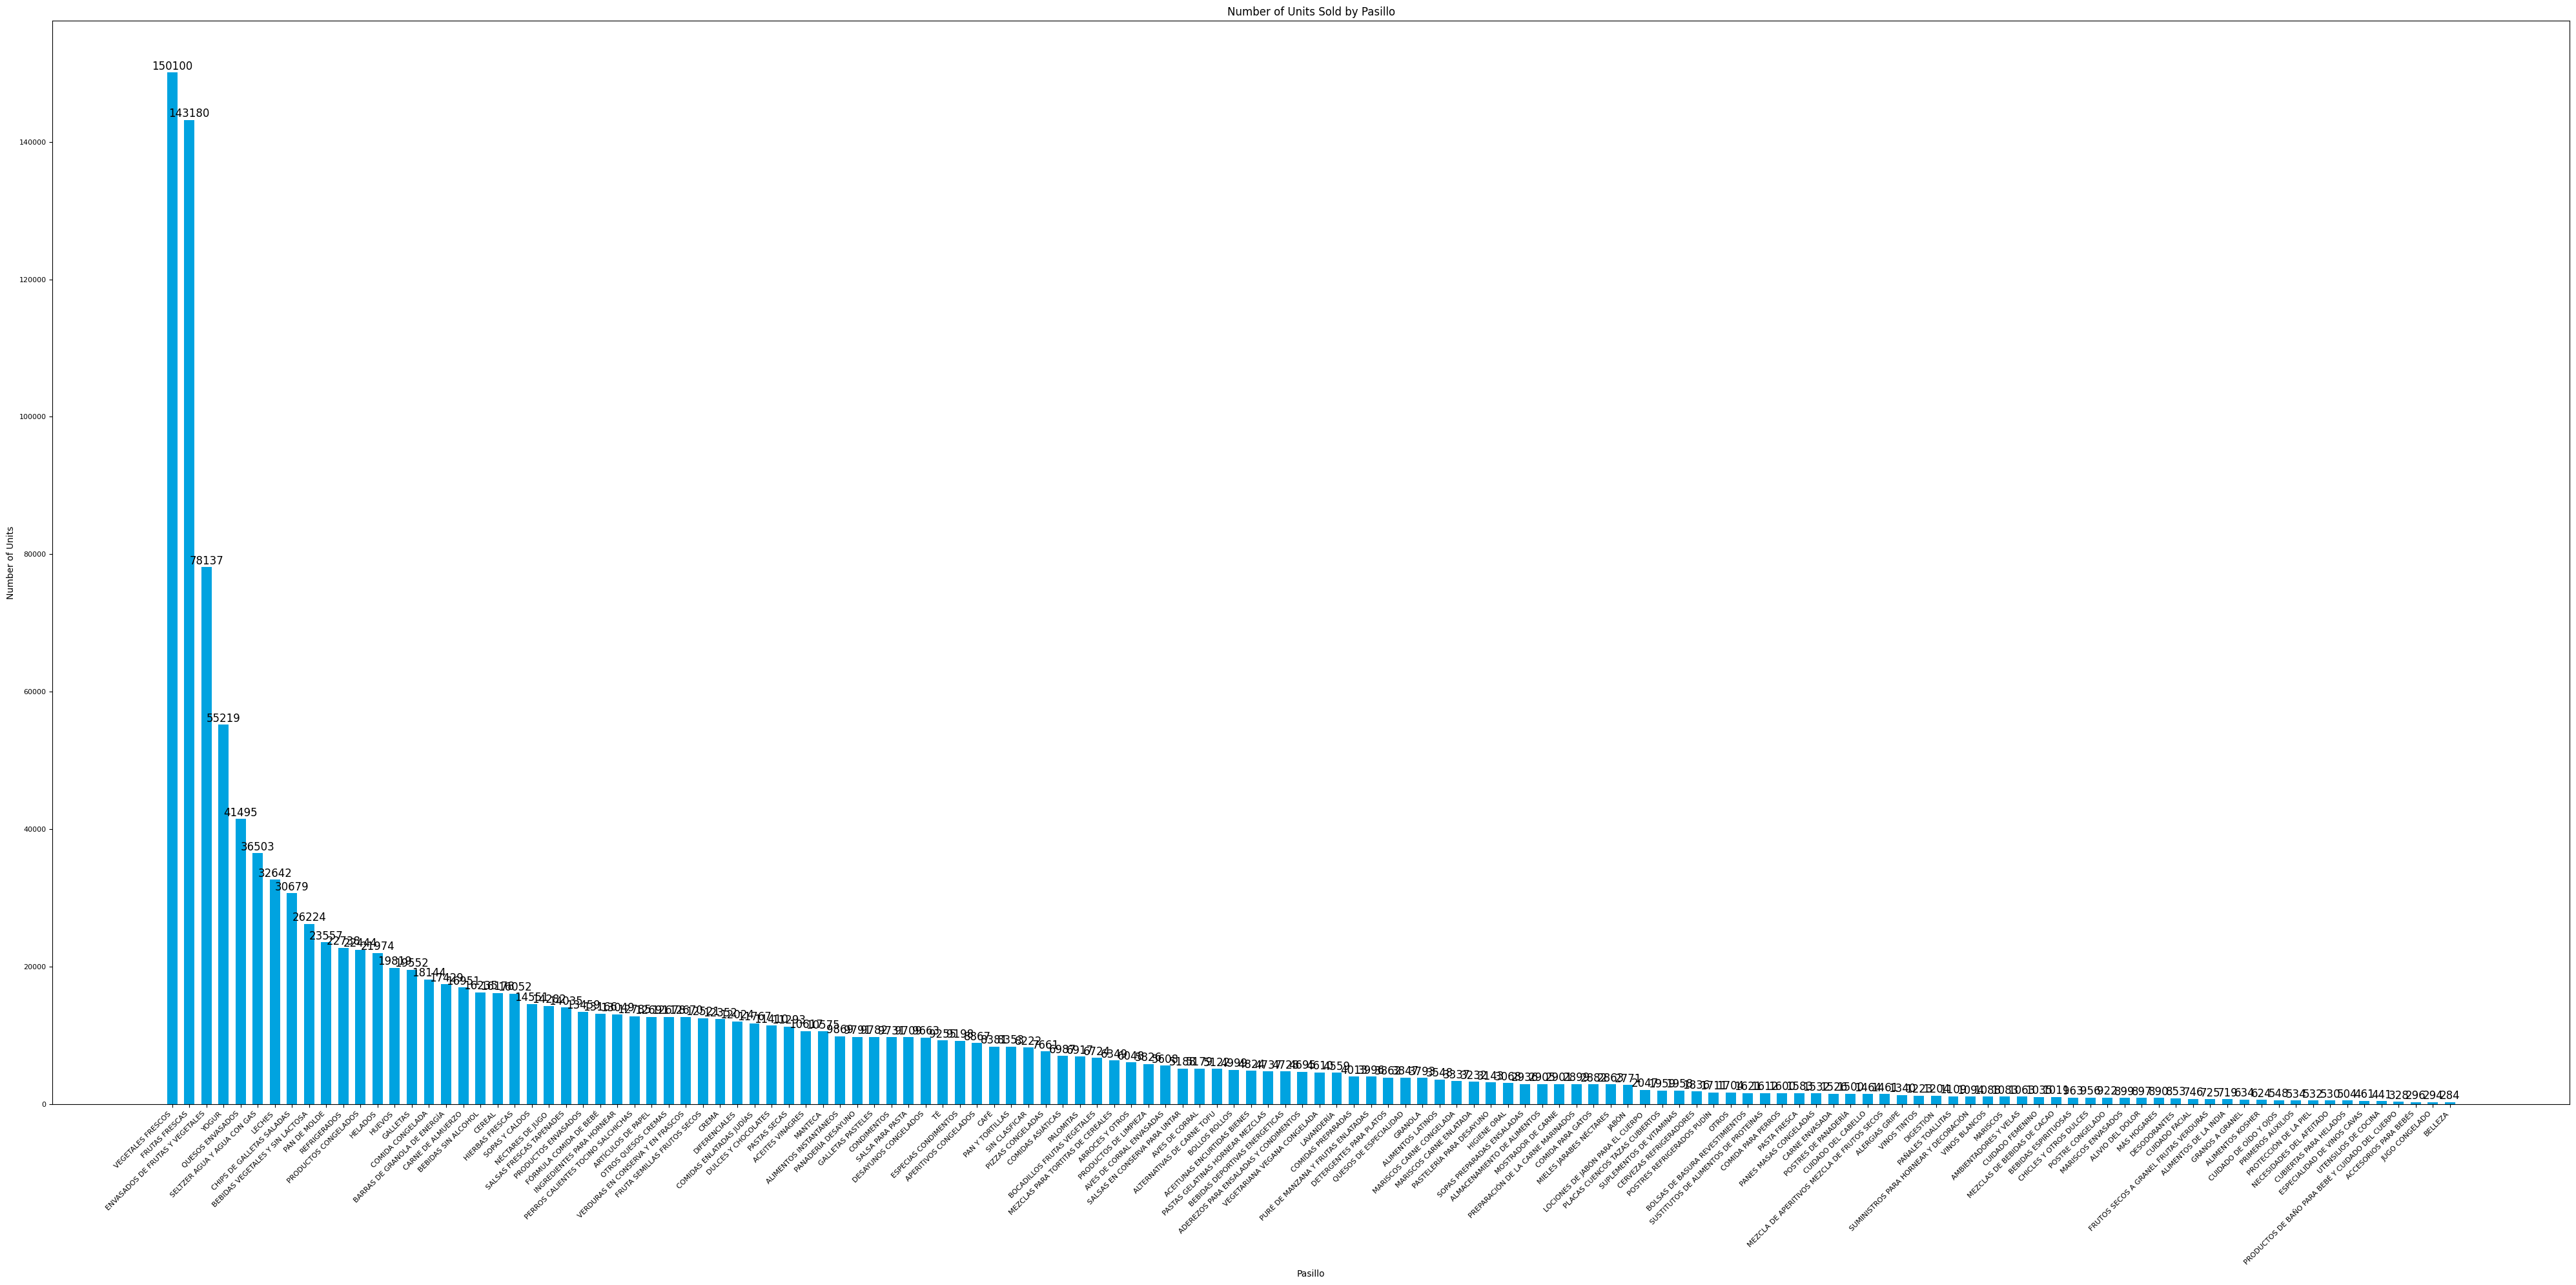

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each 'pasillo'
pasillo_units = df['pasillo'].value_counts().reset_index()
pasillo_units.columns = ['pasillo', 'units']

# Sort the DataFrame by units in descending order
pasillo_units = pasillo_units.sort_values(by='units', ascending=False)

# Create the bar chart with wider space between bars
plt.figure(figsize=(40, 20))  # Adjust figure size
bars = plt.bar(pasillo_units['pasillo'], pasillo_units['units'], color='#00A3E0', width=0.6)  # Adjust bar width
plt.title('Number of Units Sold by Pasillo')
plt.xlabel('Pasillo')
plt.ylabel('Number of Units')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust x-axis label rotation and font size
plt.yticks(fontsize=8)  # Adjust y-axis label font size
plt.tight_layout()

# Add labels to the bars with smaller font size
for bar, label in zip(bars, pasillo_units['units']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 50, label, ha='center', va='bottom', fontsize=12)  # Adjust label font size

plt.show()


How many different products are in each aisle?

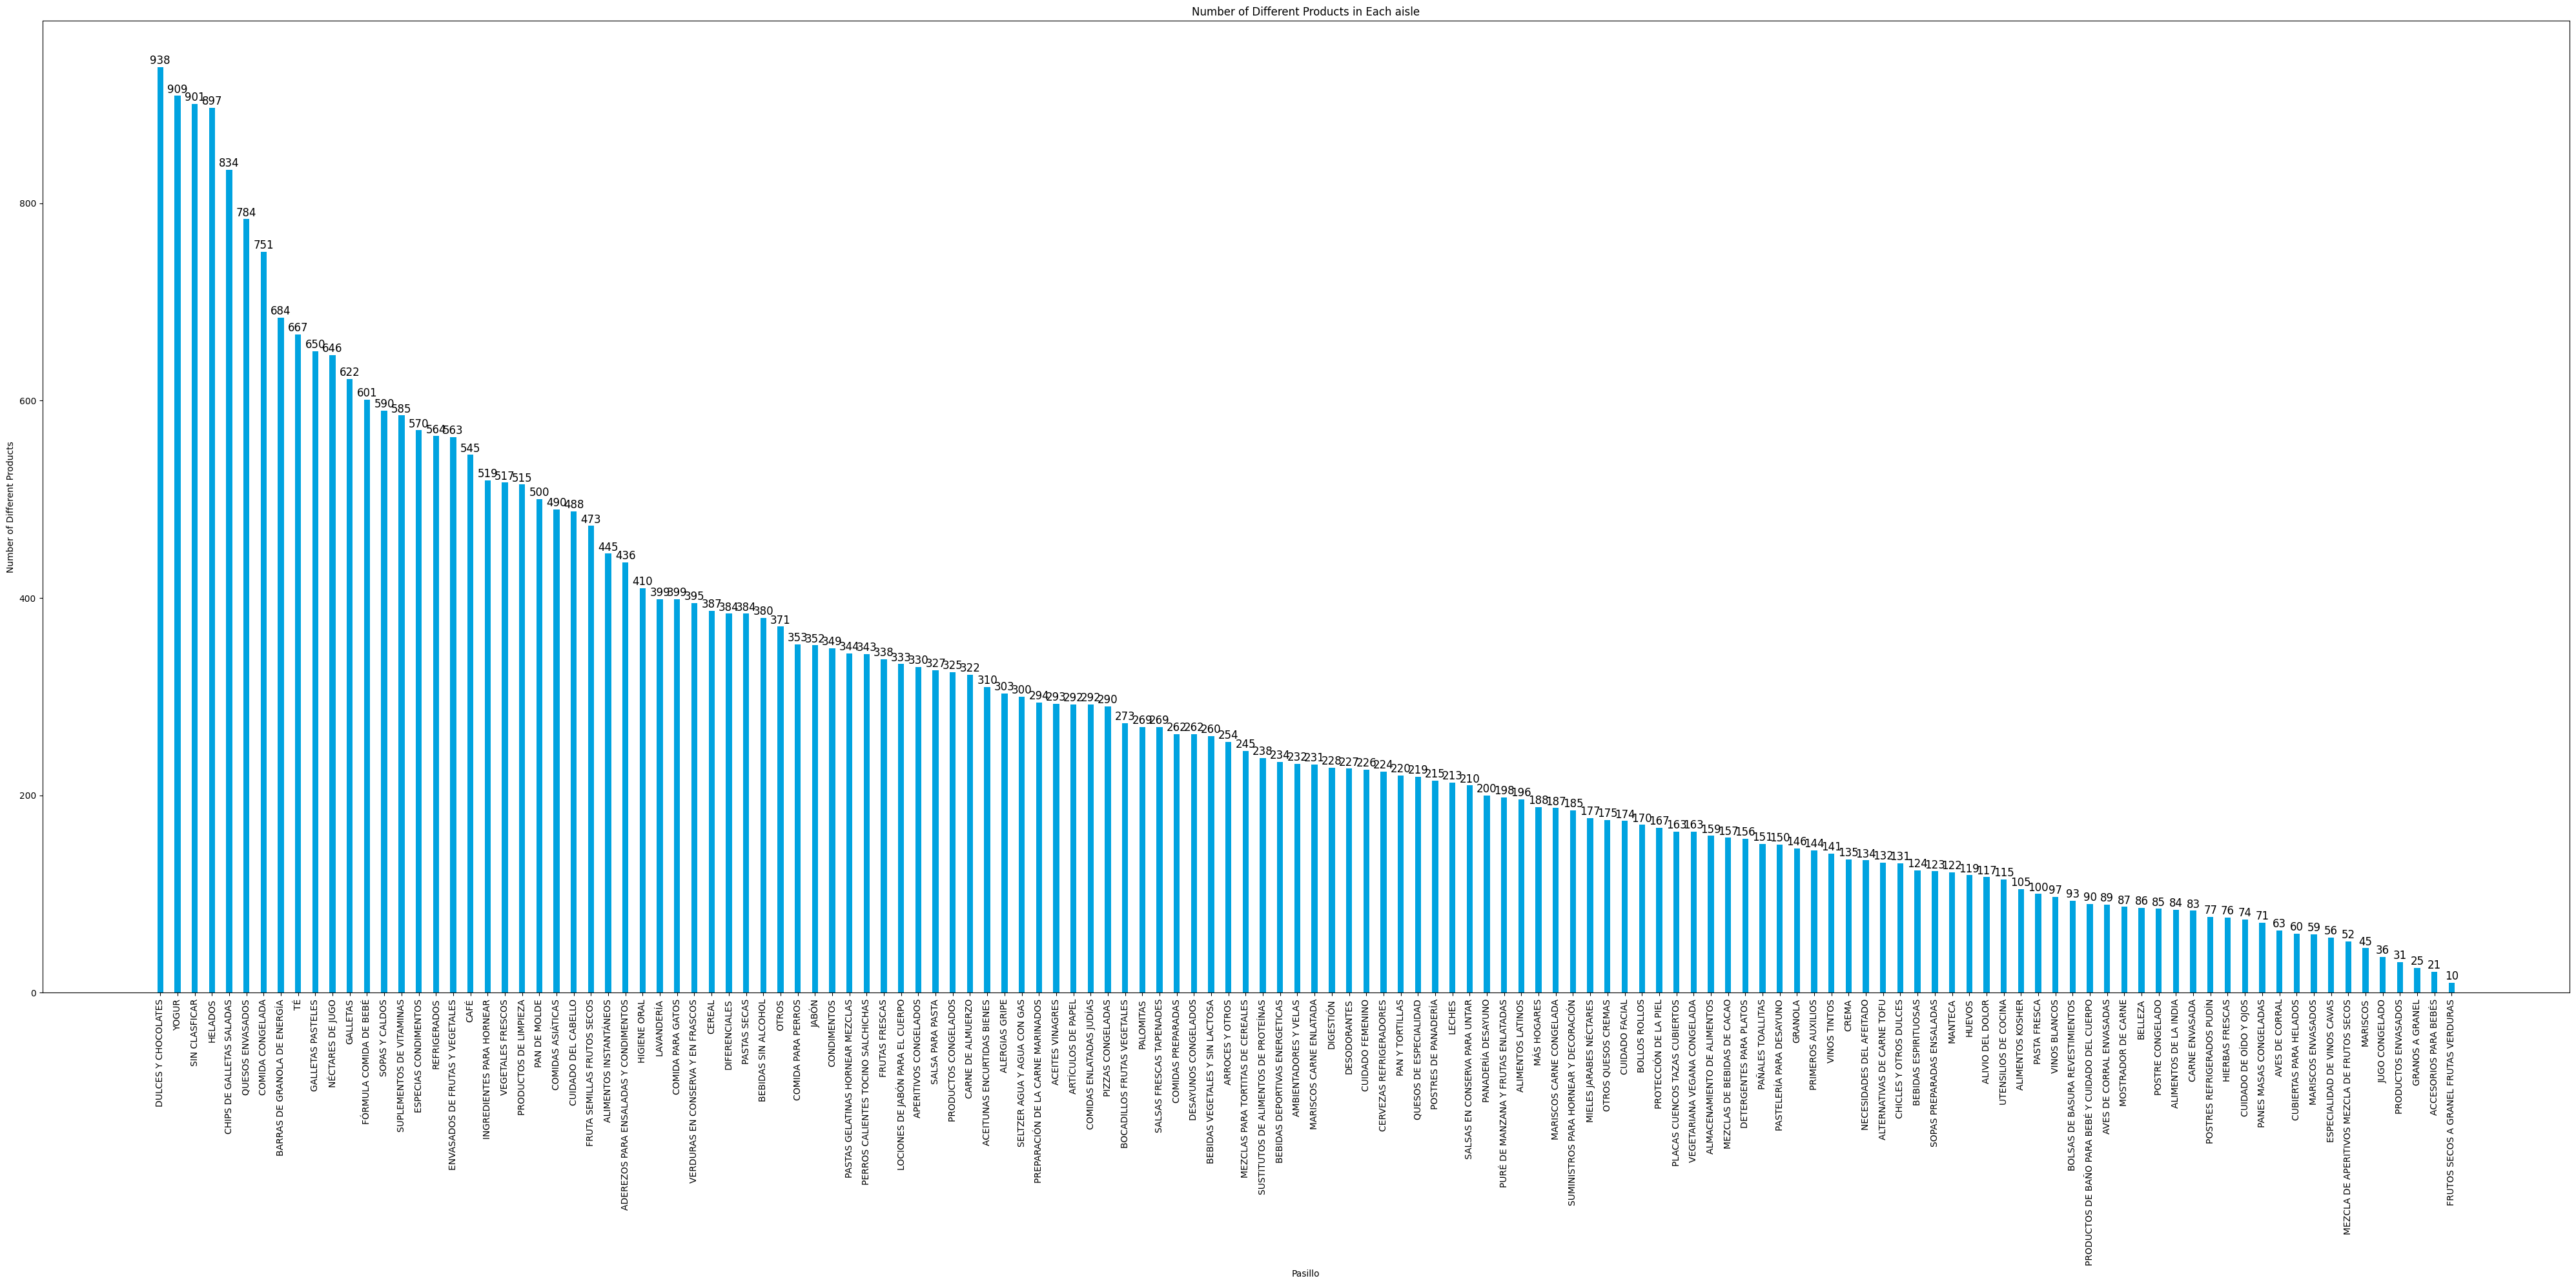

In [ ]:
# Define the width of each bar
bar_width = 0.35

# Group by aisle and count the number of unique 'id_producto' values
pasillo_product_count = df.groupby('pasillo')['id_producto'].nunique().reset_index()

# Sort the DataFrame by the number of unique products in each aisle in descending order
pasillo_product_count_sorted = pasillo_product_count.sort_values(by='id_producto', ascending=False)

# Plot the bar chart with double width
plt.figure(figsize=(40, 20))  # Double width
bars = plt.bar(pasillo_product_count_sorted['pasillo'], pasillo_product_count_sorted['id_producto'],
                color='#00A3E0', width=bar_width)
plt.title('Number of Different Products in Each aisle')
plt.xlabel('Pasillo')
plt.ylabel('Number of Different Products')
plt.xticks(rotation=90)
plt.tight_layout()

# Add text labels to each bar
for bar, label in zip(bars, pasillo_product_count_sorted['id_producto']):
    plt.text(bar.get_x() + bar_width / 2, bar.get_height() + 0.5, label, ha='center', va='bottom', fontsize=12)

plt.show()

# **Reordered Items**

***reordenado*** represents the items that have been reordered from by a customer in this ticket. Let's see statistics about this colum

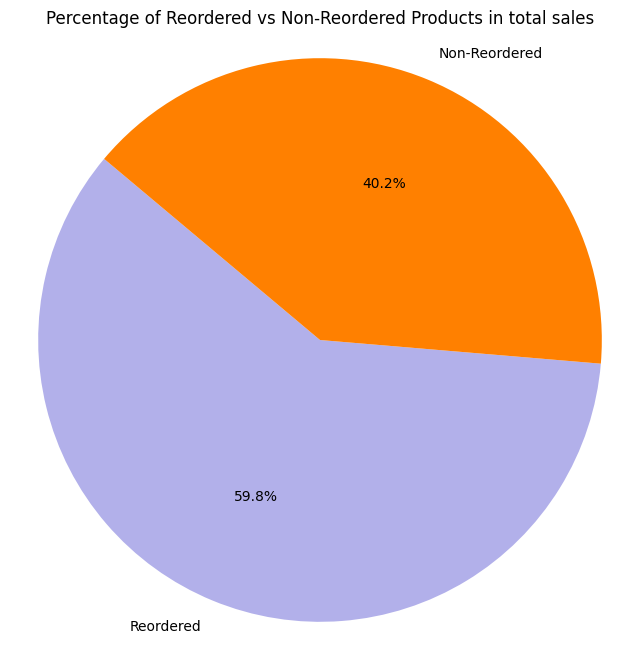

In [ ]:
# Define the percentages
reordered_percentage = (df['reordenado'].sum() / len(df)) * 100
non_reordered_percentage = 100 - reordered_percentage

# Create a list of percentages and labels
percentages = [reordered_percentage, non_reordered_percentage]
labels = ['Reordered', 'Non-Reordered']

# Define colors matching Capgemini logo
colors = ['#B2B0EA', '#FF8000']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Reordered vs Non-Reordered Products in total sales')
plt.axis('equal')
plt.show()

<ipython-input-24-47a64f37b04b>:18: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



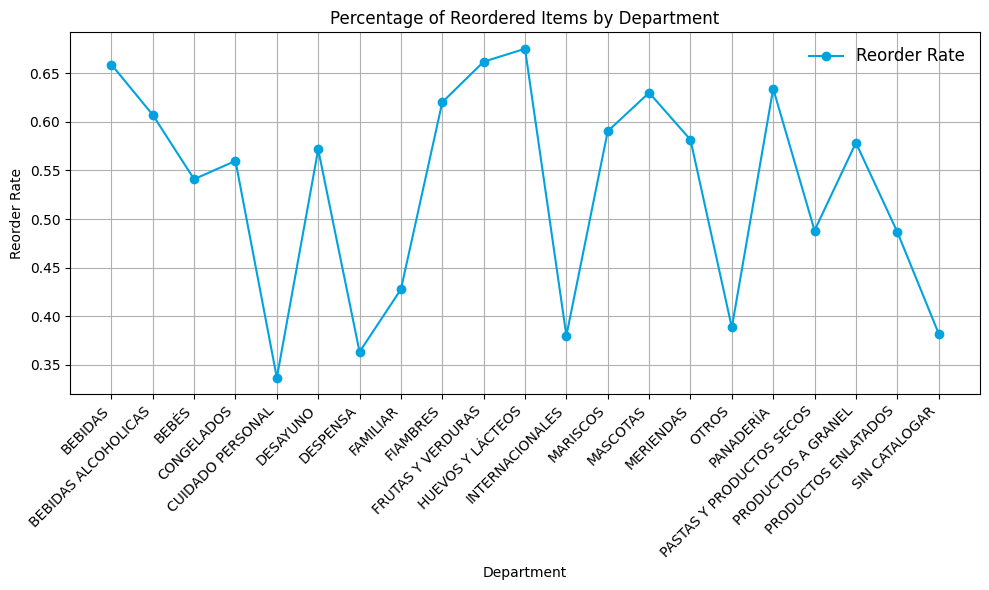

In [ ]:
# Calculate the average reorder rate for each department
department_reorder_rate = df.groupby('departamento')['reordenado'].mean().reset_index()

# Define colors matching Capgemini logo
colors = ['#00A3E0', '#FF8000']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(department_reorder_rate['departamento'], department_reorder_rate['reordenado'], marker='o', color=colors[0], linestyle='-')
plt.title('Percentage of Reordered Items by Department')
plt.xlabel('Department')
plt.ylabel('Reorder Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# Add Capgemini logo colors as labels
plt.legend(['Reorder Rate'], loc='upper right', labels=['Reorder Rate'], fontsize='large', frameon=False)
plt.show()

<ipython-input-25-22a5c8cee923>:19: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



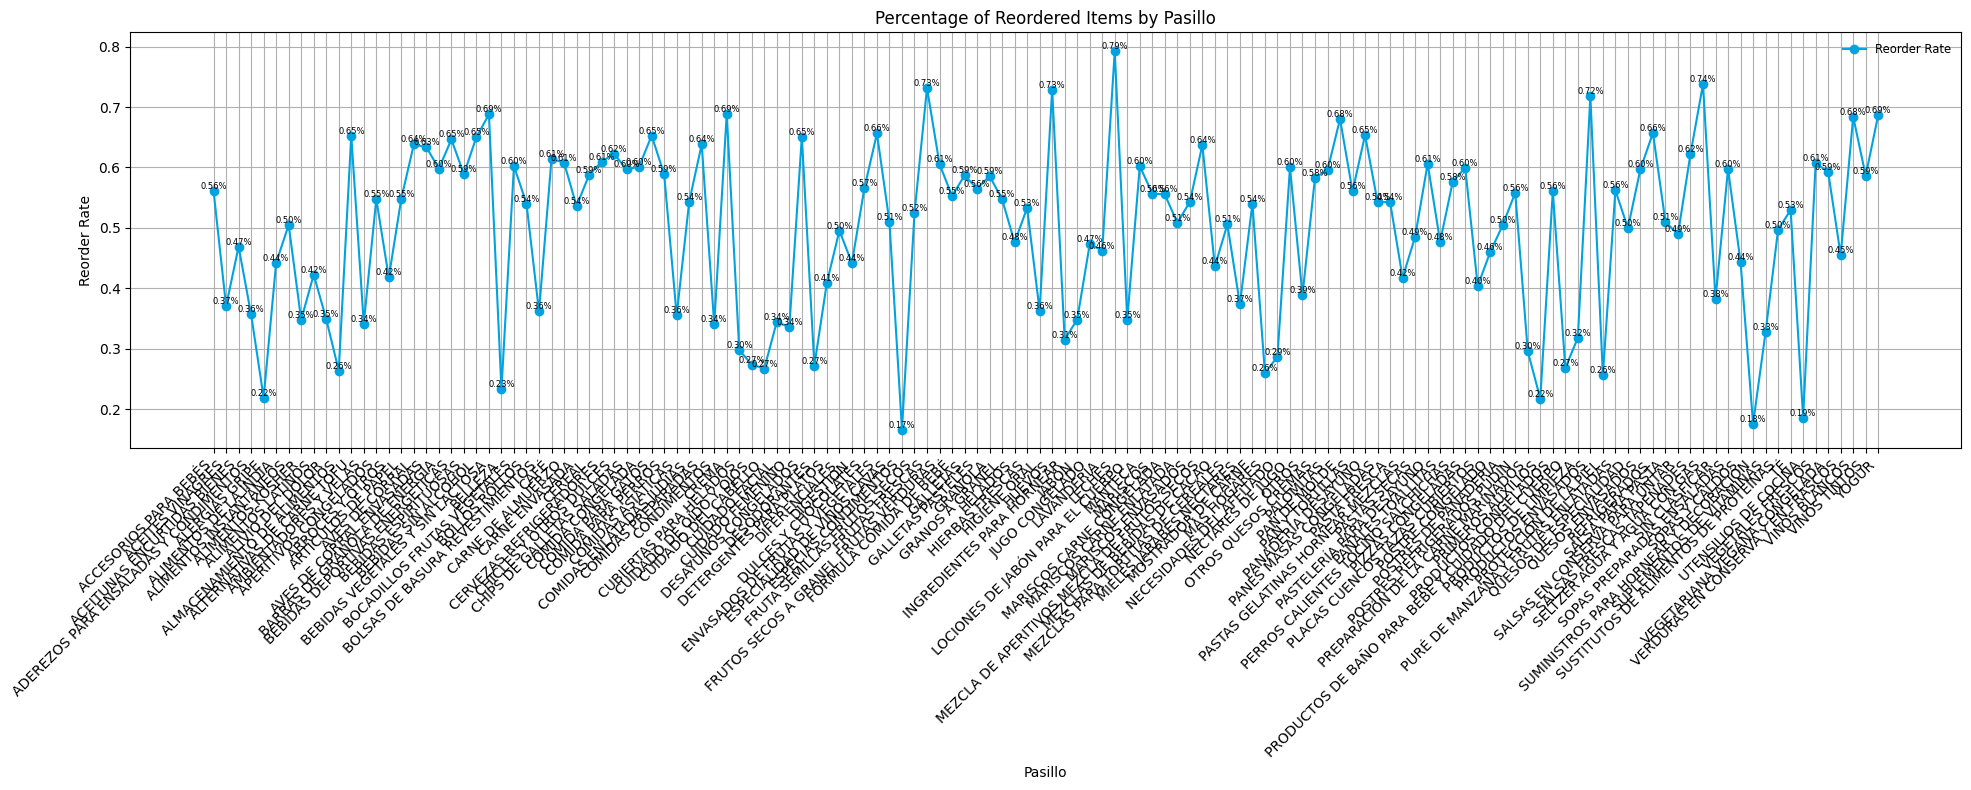

In [ ]:
# Calculate the average reorder rate for each pasillo
pasillo_reorder_rate = df.groupby('pasillo')['reordenado'].mean().reset_index()

# Define colors matching Capgemini logo
colors = ['#00A3E0', '#FF8000']

# Create the plot
plt.figure(figsize=(20, 8
                  ))
plt.plot(pasillo_reorder_rate['pasillo'], pasillo_reorder_rate['reordenado'], marker='o', color=colors[0], linestyle='-')
plt.title('Percentage of Reordered Items by Pasillo')
plt.xlabel('Pasillo')
plt.ylabel('Reorder Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()

# Add Capgemini logo colors as labels
plt.legend(['Reorder Rate'], loc='upper right', labels=['Reorder Rate'], fontsize='small', frameon=False)

# Add percentages to the plot
for i, rate in enumerate(pasillo_reorder_rate['reordenado']):
    plt.text(pasillo_reorder_rate['pasillo'][i], rate, f'{rate:.2f}%', ha='center', va='bottom', fontsize=6)

plt.show()

# **Order of inclusion in cart**

When are the products chosen by the customers?

In [ ]:
## The product chosen in the first place more times
productos_mas_pedidos_1ro = df[df['incluido_orden_carrito']==1].groupby('id_producto')['incluido_orden_carrito'].count().reset_index().sort_values(by='incluido_orden_carrito', ascending=False)
productos_mas_pedidos_1ro.columns= ("id_producto", "Cantidad")

id_to_nombre = dict(zip(df['id_producto'], df['nombre_producto']))

productos_mas_pedidos_1ro['nombre_producto'] = productos_mas_pedidos_1ro['id_producto'].map(id_to_nombre)

productos_mas_pedidos_1ro.head(25)

,id_producto,Cantidad,nombre_producto
8892,24852,4641,BANANA
4648,13176,3961,BOLSA DE BANANO ORGÁNICO
9934,27845,1152,ORGÁNICA LECHE ENTERA
17125,47766,1003,AGUACATE ORGÁNICO
7557,21137,918,FRESAS ORGÁNICAS
7843,21903,892,ESPINACA ORGÁNICA DEL BEBÉ
7038,19660,732,AGUA DE MANANTIAL
5976,16797,711,FRESAS
16020,44632,653,CHISPEANTE DE POMELO AGUA
17080,47626,587,LIMÓN GRANDE


In [ ]:
# Group by product ID and product name, count occurrences, and sort values
product_selection_counts = df.groupby(['id_producto', 'nombre_producto'])['incluido_orden_carrito'].value_counts().unstack(fill_value=0)

# Calculate total selections for each product
product_selection_counts['total'] = product_selection_counts.sum(axis=1)

# Sort by total selections in descending order
product_selection_counts = product_selection_counts.sort_values(by='total', ascending=False)

# Reset index to make 'nombre_producto' a column
product_selection_counts = product_selection_counts.reset_index()

# Calculate percentages for each selection place
product_selection_counts['1st %'] = (product_selection_counts[1] / product_selection_counts['total']) * 100
product_selection_counts['2nd %'] = (product_selection_counts[2] / product_selection_counts['total']) * 100
product_selection_counts['3rd %'] = (product_selection_counts[3] / product_selection_counts['total']) * 100
product_selection_counts['first 3 choices'] = product_selection_counts[1] + product_selection_counts[2] + product_selection_counts[3]
product_selection_counts['% first 3 choices'] = (product_selection_counts['1st %'] + product_selection_counts['2nd %'] + product_selection_counts['3rd %'])

# Select relevant columns for the table
table_columns = ['nombre_producto', 1, '1st %', 2, '2nd %', 3, '3rd %', 'first 3 choices', '% first 3 choices', 'total']

# Sort the DataFrame by the 'first 3 choices' column in descending order
product_selection_counts_sorted = product_selection_counts.sort_values(by='first 3 choices', ascending=False)

# Display the table
product_selection_counts[table_columns].head(50)




incluido_orden_carrito,nombre_producto,1,1st %,2,2nd %,3,3rd %,first 3 choices,% first 3 choices,total
0,BANANA,4641,24.783723,3197,17.072519,2267,12.106163,10105,53.962405,18726
1,BOLSA DE BANANO ORGÁNICO,3961,25.587855,2913,18.817829,1939,12.525840,8813,56.931525,15480
2,FRESAS ORGÁNICAS,918,8.426657,1102,10.115660,1121,10.290068,3141,28.832385,10894
3,ESPINACA ORGÁNICA DEL BEBÉ,892,9.116926,1062,10.854456,1066,10.895339,3020,30.866721,9784
4,LIMÓN GRANDE,587,7.215734,753,9.256300,774,9.514444,2114,25.986478,8135
5,AGUACATE ORGÁNICO,1003,13.537589,1054,14.225941,843,11.378054,2900,39.141585,7409
6,FRESAS,711,10.948568,721,11.102556,690,10.625192,2122,32.676317,6494
7,LIMAS,386,6.398144,476,7.889939,494,8.188298,1356,22.476380,6033
8,LAS FRAMBUESAS ORGÁNICAS,576,10.385864,646,11.648035,601,10.836639,1823,32.870537,5546
9,LOS ARÁNDANOS ORGÁNICOS,395,7.954088,467,9.403947,448,9.021345,1310,26.379380,4966


In [ ]:
product_selection_counts

incluido_orden_carrito,id_producto,nombre_producto,1,2,3,4,5,6,7,8,...,76,77,78,79,total,1st %,2nd %,3rd %,first 3 choices,% first 3 choices
0,24852,BANANA,4641,3197,2267,1665,1309,974,807,629,...,0,0,0,0,18726,24.783723,17.072519,12.106163,10105,53.962405
1,13176,BOLSA DE BANANO ORGÁNICO,3961,2913,1939,1326,998,817,661,511,...,0,0,0,0,15480,25.587855,18.817829,12.525840,8813,56.931525
2,21137,FRESAS ORGÁNICAS,918,1102,1121,1024,880,773,697,595,...,0,0,0,0,10894,8.426657,10.115660,10.290068,3141,28.832385
3,21903,ESPINACA ORGÁNICA DEL BEBÉ,892,1062,1066,892,820,719,614,623,...,0,0,0,0,9784,9.116926,10.854456,10.895339,3020,30.866721
4,47626,LIMÓN GRANDE,587,753,774,713,699,617,554,467,...,0,0,0,0,8135,7.215734,9.256300,9.514444,2114,25.986478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38843,9775,GOTAS PARA OÍDOS DE SECADO,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0.000000,100.000000,0.000000,1,100.000000
38844,19978,AUTÉNTICO QUESO AZUL DANÉS ESTILO,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.000000,0.000000,0.000000,0,0.000000
38845,9782,CON BOLSA DE CANELA MINI ROSQUILLAS,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.000000,0.000000,0.000000,0,0.000000
38846,9789,MELOCOTONES DEL BUÑUELO,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.000000,0.000000,0.000000,0,0.000000
